1. Large distance -> Check if mislabeled.
2. CellTypist's training data
3. Parameters

In [1]:
import pandas as pd
import numpy as np
import time

import scanpy as sc
from anndata.experimental.pytorch import AnnLoader

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchnet.meter import ClassErrorMeter, AverageValueMeter
# from torch_prototypes.modules import prototypical_network
import prototypical_network
from torch_prototypes.metrics import distortion, cost
from torch_prototypes.metrics.distortion import DistortionLoss
from  torch.distributions import multivariate_normal

import matplotlib.pyplot as plt
import seaborn as sns

import helper_fns
import vanilla_vae

import igraph as ig
from sklearn.decomposition import TruncatedSVD
from anndata import AnnData

Dataset Loading, Label & Hierarchical encoding & Preprocessing

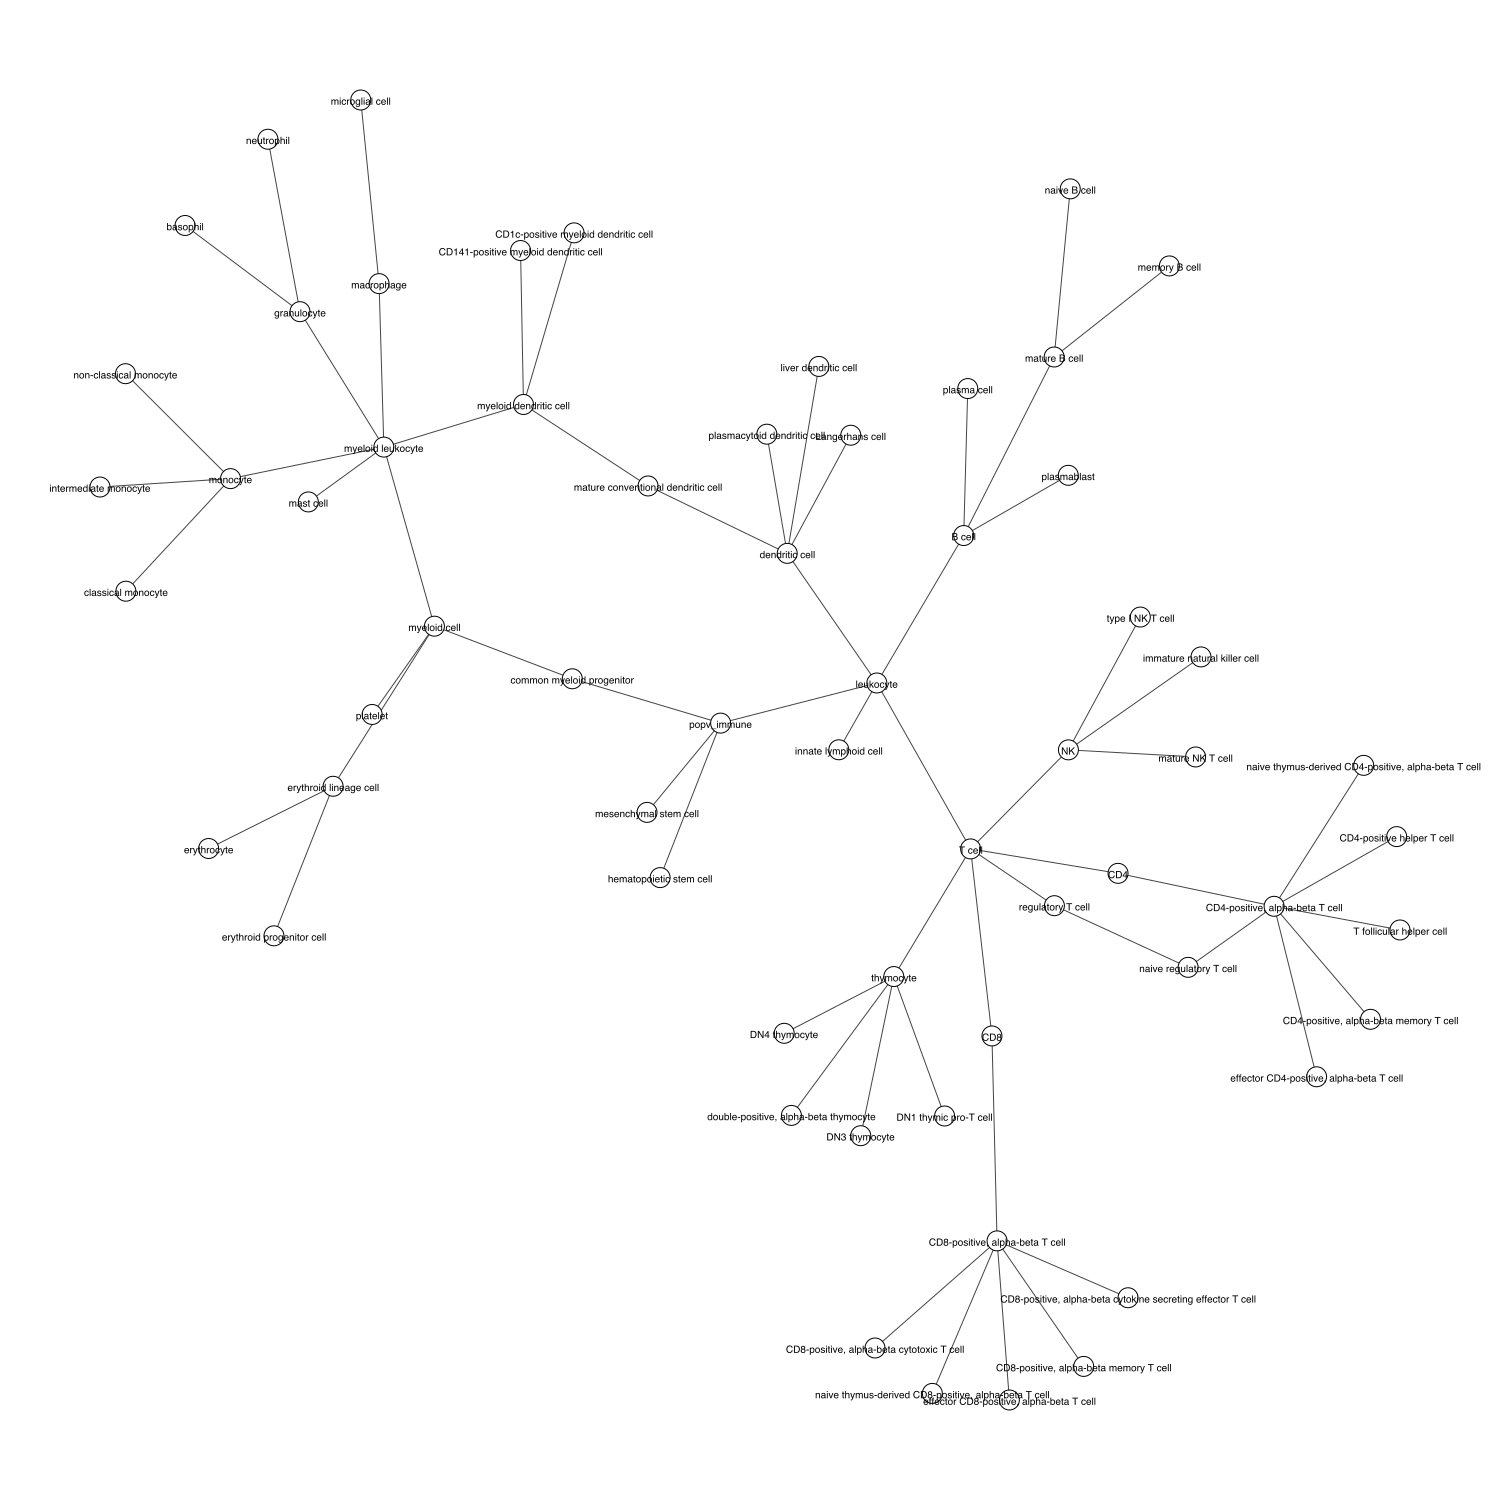

In [2]:
dataset = sc.read("/Volumes/SSD/popv_immune.h5ad")
# Load dataset
list_celltypes = dataset.obs['cell_type'].unique().tolist()

# Label encoder // No problem
encoder_celltype = LabelEncoder()
encoder_celltype.fit(dataset.obs['cell_type'])

# Get the list of filtered celltypes // No problem
list_ct = dataset.obs['cell_type'].unique().tolist()
# Transform list of filtered celltypes to list of numbers // No problem
list_num_ct = encoder_celltype.transform(list_ct)
# These are higher level celltypes // No problem
list_inner_nodes = ['popv_immune', 'myeloid leukocyte', 'mature B cell', 'NK', 'CD4', 'CD8']
all_nodes = list_ct + list_inner_nodes

# The label encoder for inner nodes (High level celltype) // No problem
encoder_celltype_inner = LabelEncoder()
encoder_celltype_inner.fit(list_inner_nodes)

# The transform function for both inner nodes and detailed celltypes // No problem
def transform(x):
    if x in list_inner_nodes:
        return encoder_celltype_inner.transform([x])[0] + len(list_ct)
    else:
        return encoder_celltype.transform([x])[0]

# Initialize the hierarchical tree // No problem
g = ig.Graph()
g.add_vertices(len(all_nodes))
g.vs['name'] = np.append(encoder_celltype.inverse_transform(list(range(len(list_ct)))), encoder_celltype_inner.inverse_transform(list(range(len(list_inner_nodes)))))
g.add_edges([(transform('popv_immune'), transform('mesenchymal stem cell')),
             (transform('popv_immune'), transform('hematopoietic stem cell')),
             (transform('popv_immune'), transform('leukocyte')),
             (transform('popv_immune'), transform('common myeloid progenitor')),

             (transform('common myeloid progenitor'), transform('myeloid cell')),
             (transform('myeloid cell'), transform('platelet')),
             (transform('myeloid cell'), transform('erythroid lineage cell')),
             (transform('myeloid cell'), transform('myeloid leukocyte')),
             
             (transform('erythroid lineage cell'), transform('erythroid progenitor cell')),
             (transform('erythroid lineage cell'), transform('erythrocyte')),
             (transform('myeloid leukocyte'), transform('monocyte')),
             (transform('myeloid leukocyte'), transform('mast cell')),
             (transform('myeloid leukocyte'), transform('macrophage')),
             (transform('myeloid leukocyte'),transform('granulocyte')),
             (transform('myeloid leukocyte'), transform('myeloid dendritic cell')),

             (transform('monocyte'), transform('classical monocyte')),
             (transform('monocyte'), transform('intermediate monocyte')),
             (transform('monocyte'), transform('non-classical monocyte')),

             (transform('macrophage'), transform('microglial cell')),

             (transform('granulocyte'), transform('basophil')),
             (transform('granulocyte'), transform('neutrophil')),

             (transform('myeloid dendritic cell'), transform('CD1c-positive myeloid dendritic cell')),
             (transform('myeloid dendritic cell'), transform('CD141-positive myeloid dendritic cell')),

             (transform('leukocyte'), transform('dendritic cell')),
             (transform('leukocyte'), transform('innate lymphoid cell')),
             (transform('leukocyte'), transform('B cell')),
             (transform('leukocyte'), transform('T cell')),

             (transform('dendritic cell'), transform('liver dendritic cell')),
             (transform('dendritic cell'), transform('mature conventional dendritic cell')),
             (transform('dendritic cell'), transform('plasmacytoid dendritic cell')),
             (transform('dendritic cell'), transform('Langerhans cell')),
             (transform('mature conventional dendritic cell'), transform('myeloid dendritic cell')),
             
             (transform('B cell'), transform('mature B cell')),
             (transform('B cell'), transform('plasma cell')),
             (transform('B cell'), transform('plasmablast')),
             
             (transform('mature B cell'), transform('naive B cell')),
             (transform('mature B cell'), transform('memory B cell')),

             (transform('T cell'), transform('CD8')),
             (transform('T cell'), transform('CD4')),
             (transform('T cell'), transform('regulatory T cell')),
             (transform('T cell'), transform('thymocyte')),
             (transform('T cell'), transform('NK')),

             (transform('CD8'), transform('CD8-positive, alpha-beta T cell')),
             (transform('CD8-positive, alpha-beta T cell'), transform('CD8-positive, alpha-beta cytokine secreting effector T cell')),
             (transform('CD8-positive, alpha-beta T cell'), transform('effector CD8-positive, alpha-beta T cell')),
             (transform('CD8-positive, alpha-beta T cell'), transform('CD8-positive, alpha-beta memory T cell')),
             (transform('CD8-positive, alpha-beta T cell'), transform('CD8-positive, alpha-beta cytotoxic T cell')),
             (transform('CD8-positive, alpha-beta T cell'), transform('naive thymus-derived CD8-positive, alpha-beta T cell')),

             (transform('CD4'), transform('CD4-positive, alpha-beta T cell')),
             (transform('CD4-positive, alpha-beta T cell'), transform('CD4-positive helper T cell')),
             (transform('CD4-positive, alpha-beta T cell'), transform('naive thymus-derived CD4-positive, alpha-beta T cell')),
             (transform('CD4-positive, alpha-beta T cell'), transform('CD4-positive, alpha-beta memory T cell')),
             (transform('CD4-positive, alpha-beta T cell'), transform('effector CD4-positive, alpha-beta T cell')),
             (transform('CD4-positive, alpha-beta T cell'), transform('T follicular helper cell')),
             (transform('CD4-positive, alpha-beta T cell'), transform('naive regulatory T cell')),

             (transform('regulatory T cell'), transform('naive regulatory T cell')),

             (transform('thymocyte'), transform('double-positive, alpha-beta thymocyte')),
             (transform('thymocyte'), transform('DN3 thymocyte')),
             (transform('thymocyte'), transform('DN4 thymocyte')),
             (transform('thymocyte'), transform('DN1 thymic pro-T cell')),

             (transform('NK'), transform('mature NK T cell')),
             (transform('NK'), transform('immature natural killer cell')),
             (transform('NK'), transform('type I NK T cell'))
             ])

g.write('popv_immune_tree', format='gml')
layout = g.layout("kamada_kawai")
ig.plot(g, layout=layout, vertex_label=g.vs["name"], vertex_label_size=10, vertex_size=20, bbox=(1500, 1500), margin=100, vertex_color='white')

In [3]:
# return the shortest distance between two nodes // No problem
def get_shortest_dist(node_1, node_2, graph):
    return len(graph.get_shortest_paths(node_1, node_2)[0])-1
 
# Construct the distance matrix, init with 0 // No problem
dist_df = pd.DataFrame(0, index=np.arange(len(list_num_ct)), columns=np.arange(len(list_num_ct)))
for i in range(len(list_num_ct)):
    for j in range(len(list_num_ct)):
        dist_df.iloc[i, j]=get_shortest_dist(i, j, g)

# Convert to tensor // No problem
D = dist_df
D = torch.tensor(D.values, dtype=float)

# Train test split // No problem
train_indices, test_indices, cv = helper_fns.costumized_train_test_split(dataset, cross_validation=False, obs_key='cell_type', k_fold=5)
sc.pp.normalize_total(dataset, 1e4)
sc.pp.log1p(dataset)
pca = TruncatedSVD(n_components=128)
pca.fit(dataset[train_indices].X)
dataset_pca = AnnData(pca.transform(dataset.X))
dataset_pca.obs = dataset.obs
dataset = dataset_pca

train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)

# Define data loaders for training and testing data in this fold
encoders = {
    'obs': {
        'cell_type': encoder_celltype.transform
    }
}
dataloader_training = AnnLoader(dataset, batch_size=512, convert=encoders, sampler=train_subsampler)
dataloader_testing = AnnLoader(dataset, batch_size=512, convert=encoders, sampler=test_subsampler)

In [4]:
# Get number of cells by cell type
def get_num_by_ct(label, dataset):
    return len(dataset.obs[dataset.obs['cell_type'] == label])

weights = []
for i in range(len(list_num_ct)):
    weights.append(get_num_by_ct(encoder_celltype.inverse_transform([i])[0], dataset))
weights = torch.tensor(weights, dtype=float)

In [5]:
# Pytorch version of the 3 fully connected layers
# No problem
class Net(nn.Module):
    def __init__(self, mode, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size):
        super(Net, self).__init__()
        self.mode = mode
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.fc4 = nn.Linear(hidden_size_3, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# No problem
class PL(nn.Module):
    def __init__(self, centers, weights, vars):
        super(PL, self).__init__()
        self.centers = centers
        self.weights = weights
        self.vars = vars

    def forward(self, mapping, labels):
        # Find prototype by labels
        targets = torch.index_select(self.centers, 0, labels)
        # Sum the distance between each point and its prototype
        weights = torch.index_select(self.weights, 0, labels)
        log_vars = torch.log(torch.index_select(self.vars, 0, labels))
        # dist = torch.norm(mapping - targets, dim=1)/weights
        # return torch.sum(dist)/mapping.shape[0]
        likelihood = -helper_fns.log_likelihood_student(mapping, targets, log_vars)/weights
        return torch.sum(likelihood)/mapping.shape[0]
        # return torch.sum(likelihood)/mapping.shape[0]

In [21]:
embedding_dim = 8

In [6]:
def train(mode, loss_mode, epochs=30, cuda=1):
    if torch.cuda.is_available():
        D_metric = D.cuda()
    else:
        D_metric = D
    # A simple neural network no problem
    if mode == 'Net':
        if torch.cuda.is_available():
            model = Net(mode, 128, 32, 37).cuda()
        else:
            model = Net(mode, 128, 32, 37)
    # Learnt prototype & Simple neural network encoder no problem
    elif mode == 'Proto_Net':
        if torch.cuda.is_available():
            model = Net(mode, 128, 32, embedding_dim).cuda()
            centers = []
            vars = []
            for i in range(len(list_num_ct)):
                out = model(torch.tensor(dataset[dataset.obs['cell_type'] == encoder_celltype.inverse_transform([i])[0]].X))
                centers.append(np.array(torch.mean(out, dim=0)))
                vars.append(np.array(torch.var(out, dim=0)))
            centers = torch.tensor(centers, dtype=float).cuda()
            vars = torch.tensor(vars, dtype=float).cuda()
            model = prototypical_network.LearntPrototypes(model, n_prototypes= D.shape[0],
                    prototypes=centers, vars=vars, embedding_dim=embedding_dim, device='cuda').cuda()
        else:
            model = Net(mode, 128, 64, 32, 16, embedding_dim)
            centers = []
            vars = []
            for i in range(len(list_num_ct)):
                out = model(torch.tensor(dataset[dataset.obs['cell_type'] == encoder_celltype.inverse_transform([i])[0]].X))
                centers.append(np.array(torch.mean(out, dim=0).detach()))
                vars.append(np.array(torch.var(out, dim=0).detach()))
            centers = torch.tensor(centers, dtype=float)
            vars = torch.tensor(vars, dtype=float)
            model = prototypical_network.LearntPrototypes(model, n_prototypes= D.shape[0],
                    prototypes=centers, vars=vars, embedding_dim=embedding_dim, device='cpu')
    # Cross entropy loss no problem
    criterion = nn.CrossEntropyLoss()
    # Distortion loss no problem
    delta = DistortionLoss(D_metric)
    opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    # Train & Test model, no problem
    for epoch in range(1, epochs+1):
        print('Epoch {}'.format(epoch))
        ER_meter = ClassErrorMeter(accuracy=False)

        model.train()
        t0 = time.time()
        for batch in dataloader_training:
            if torch.cuda.is_available():
                x = batch.X.cuda()
                y = batch.obs['cell_type'].type(torch.LongTensor).cuda()
            else:
                x = batch.X
                y = batch.obs['cell_type'].type(torch.LongTensor)
            y = y.squeeze()
            y.long()
            if mode == 'Net':
                out = model(x)
            elif mode == 'Proto_Net':
                out, embeddings = model(x)
            opt.zero_grad()
            xe_loss = criterion(out, y)
            loss = xe_loss
            if 'pl' in loss_mode:
                # print(model.prototypes.shape)
                # print(model.vars.shape)
                
                pl_loss = PL(centers = model.prototypes.data, weights=weights, vars=model.vars)
                pl_loss_ = pl_loss(embeddings, y)
                loss = loss + 1000*pl_loss_
            if 'disto' in loss_mode:
                disto_loss = delta(model.prototypes)
                loss = loss + disto_loss
            loss.backward()
            opt.step()
            pred = out.detach()
            ER_meter.add(pred.cpu(),y.cpu())
        vars = []
        if mode == 'Proto_Net':
            if torch.cuda.is_available():
                for i in range(len(list_num_ct)):
                    out, embeddings = model(torch.tensor(dataset[dataset.obs['cell_type'] == encoder_celltype.inverse_transform([i])[0]].X)).cpu()
                    vars.append(np.array(torch.var(embeddings, dim=0).detach().cpu()))
                model.vars = torch.tensor(vars, dtype=float).cuda()
            else:
                for i in range(len(list_num_ct)):
                    out, embeddings = model(torch.tensor(dataset[dataset.obs['cell_type'] == encoder_celltype.inverse_transform([i])[0]].X))
                    # out = model(dataset.obs['cell_type'] == encoder_celltype.inverse_transform([i])[0])
                    vars.append(np.array(torch.var(embeddings, dim=0).detach()))
                model.vars = torch.tensor(vars, dtype=float)
        t1 = time.time()
        
        print('Train ER {:.2f}, time {:.1f}s'.format(ER_meter.value()[0], t1-t0))

        model.eval()
        ER_meter = ClassErrorMeter(accuracy=False)
        t0 = time.time()
        for batch in dataloader_testing:
            if torch.cuda.is_available():
                x = batch.X.cuda()
                y = batch.obs['cell_type'].type(torch.LongTensor).cuda()
            else:
                x = batch.X
                y = batch.obs['cell_type'].type(torch.LongTensor)
            y = y.squeeze()
            y.long()
            if mode == 'Net':
                with torch.no_grad():
                    out = model(x)
            elif mode == 'Proto_Net':
                with torch.no_grad():
                    out, embeddings = model(x)
            pred = out.detach()
            ER_meter.add(pred.cpu(),y)
        t1 = time.time()
        print('Test ER {:.2f}, time {:.1f}s'.format(ER_meter.value()[0], t1-t0))
    return model

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(mode, model):
    y_test = dataset[test_indices].obs['cell_type']
    if mode == 'Net':
        if torch.cuda.is_available():
            y_pred = model(torch.tensor(dataset[test_indices].X).cuda())
        else:
            y_pred = model(torch.tensor(dataset[test_indices].X))
    elif mode == 'Proto_Net':
        if torch.cuda.is_available():
            y_pred, y_embeddings = model(torch.tensor(dataset[test_indices].X).cuda())
        else:
            y_pred, y_embeddings = model(torch.tensor(dataset[test_indices].X))
    y_pred = y_pred.detach().cpu().numpy()
    pred = encoder_celltype.inverse_transform(y_pred.argmax(axis=1))
    cm=confusion_matrix(y_test, pred)
    # Normalise
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(50,50))
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['cell_type'].unique().tolist()))),
                                        yticklabels=encoder_celltype.inverse_transform(range(len(dataset.obs['cell_type'].unique().tolist()))))
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show(block=False)

def plot_distance_matrix(mode, model):
    y_test = encoder_celltype.transform(dataset[test_indices].obs['cell_type'])
    if mode == 'Net':
        if torch.cuda.is_available():
            y_pred = model(torch.tensor(dataset[test_indices].X).cuda())
        else:
            y_pred = model(torch.tensor(dataset[test_indices].X))
    elif mode == 'Proto_Net':
        if torch.cuda.is_available():
            y_pred, y_embeddings = model(torch.tensor(dataset[test_indices].X).cuda())
        else:
            y_pred, y_embeddings = model(torch.tensor(dataset[test_indices].X))
    y_pred = y_pred.detach().cpu().numpy()
    y_pred = y_pred.argmax(axis=1)
    dist_list = []
    for i in range(len(y_pred)):
        distance = dist_df.iloc[y_pred[i], y_test[i]]
        dist_list.append(distance)
    print(np.mean(np.array(dist_list)))
    sns.displot(dist_list)
    plt.show(block=False)



Epoch 1
Train ER 56.72, time 5.9s
Test ER 47.30, time 0.6s
Epoch 2
Train ER 43.08, time 5.8s
Test ER 41.25, time 0.6s
Epoch 3
Train ER 40.20, time 5.9s
Test ER 39.46, time 0.5s
Epoch 4
Train ER 38.38, time 5.9s
Test ER 37.46, time 0.6s
Epoch 5
Train ER 35.90, time 5.9s
Test ER 35.41, time 0.6s
Epoch 6
Train ER 33.93, time 5.9s
Test ER 33.00, time 0.6s
Epoch 7
Train ER 31.93, time 6.1s
Test ER 30.62, time 0.5s
Epoch 8
Train ER 29.87, time 6.0s
Test ER 29.31, time 0.6s
Epoch 9
Train ER 28.60, time 6.2s
Test ER 28.02, time 0.6s
Epoch 10
Train ER 27.39, time 6.1s
Test ER 27.33, time 0.7s
Epoch 11
Train ER 26.55, time 6.1s
Test ER 26.40, time 0.6s
Epoch 12
Train ER 25.90, time 5.9s
Test ER 25.48, time 0.6s
Epoch 13
Train ER 24.86, time 5.9s
Test ER 25.26, time 0.6s
Epoch 14
Train ER 24.35, time 5.9s
Test ER 24.76, time 0.6s
Epoch 15
Train ER 23.72, time 6.0s
Test ER 23.36, time 0.5s
Epoch 16
Train ER 23.03, time 5.9s
Test ER 22.86, time 0.6s
Epoch 17
Train ER 22.70, time 5.9s
Test ER 22.41,

/var/folders/hk/lwlgjk2975n6fqbwkl1b7ny40000gq/T/ipykernel_47132/3627010182.py:21: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


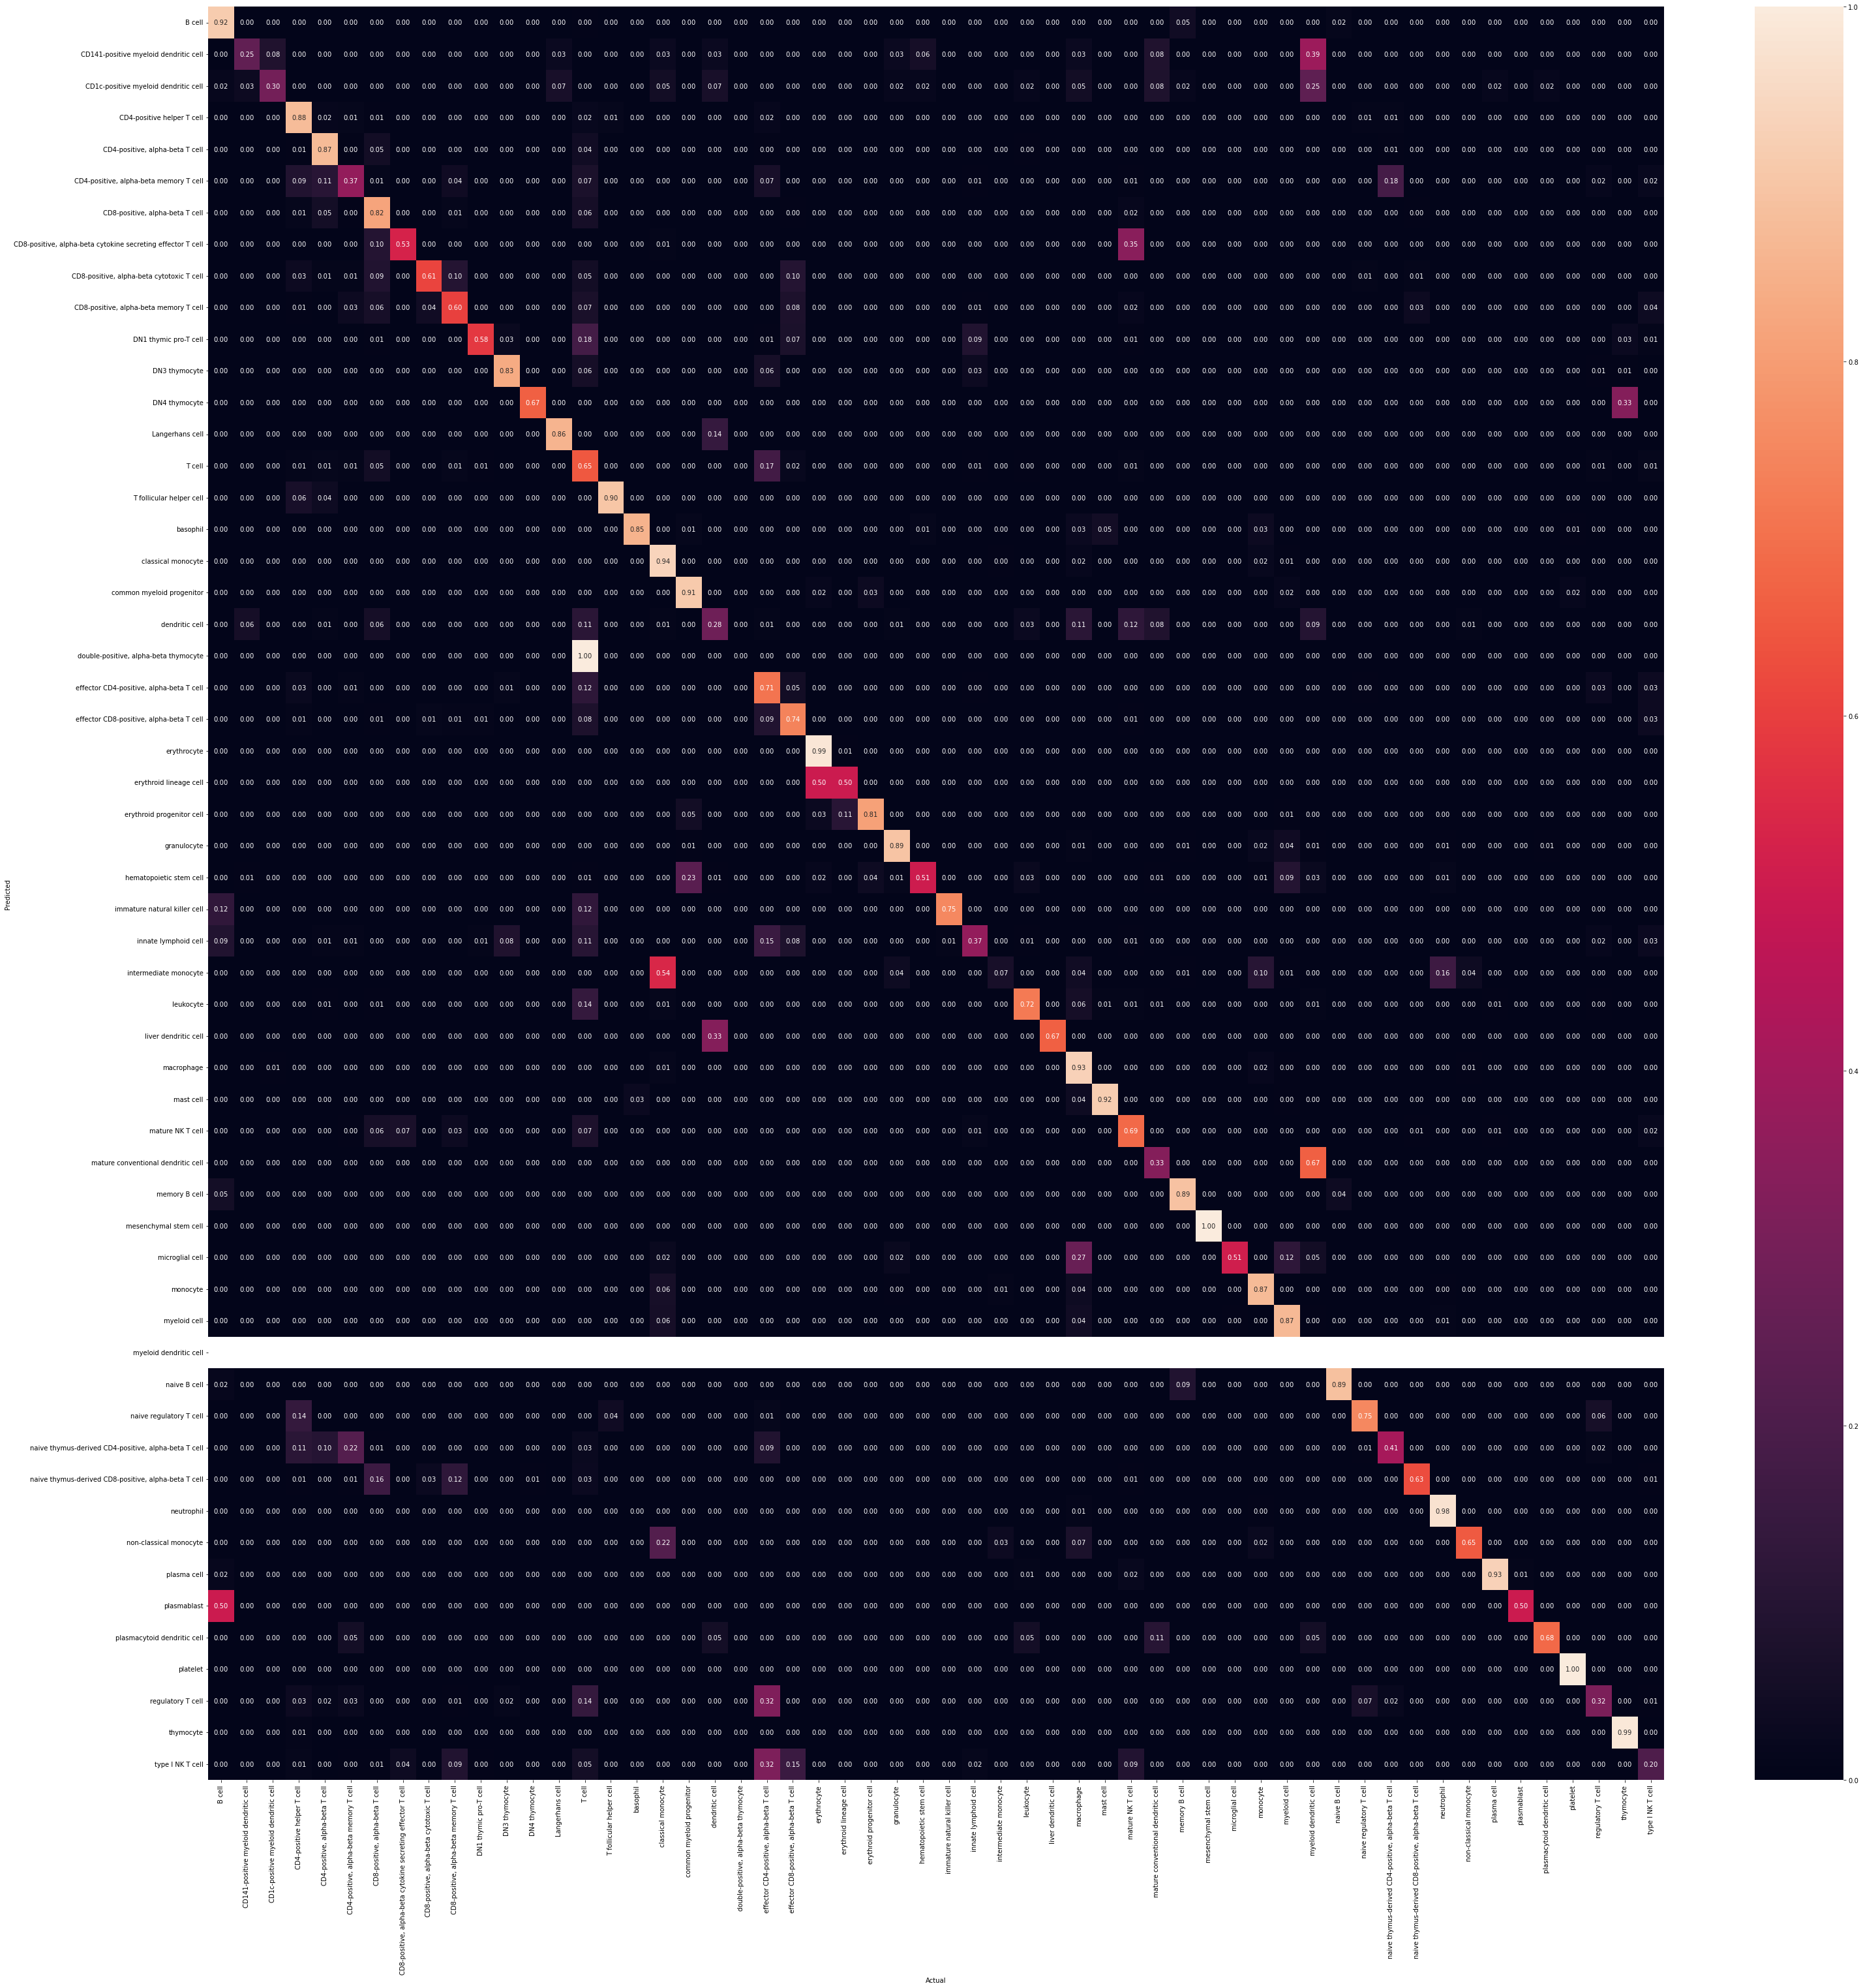

In [22]:
mode='Proto_Net'
loss_mode='disto_pl'
model = train(mode=mode, loss_mode=loss_mode, epochs=50)
plot_confusion_matrix(mode, model)
torch.save(model.state_dict(), './models/'+mode+'_'+loss_mode+'.pt')

Plots

In [17]:
embedding_prototypes = model.prototypes.detach().cpu().numpy()
embedding_prototypes_labels = encoder_celltype.inverse_transform(range(len(dataset.obs['cell_type'].unique().tolist())))

Training data

In [18]:
# Training
training_out, training_embeddings = model(torch.tensor(dataset[train_indices].X))
training_embeddings_true_labels = dataset[train_indices].obs['cell_type']
training_embeddings_pred_labels = []
training_embeddings = training_embeddings.detach().cpu().numpy()
training_out = training_out.detach().cpu().numpy()
for i in range(len(training_out)):
    training_embeddings_pred_labels.append(encoder_celltype.inverse_transform([training_out[i].argmax()])[0])

True labels

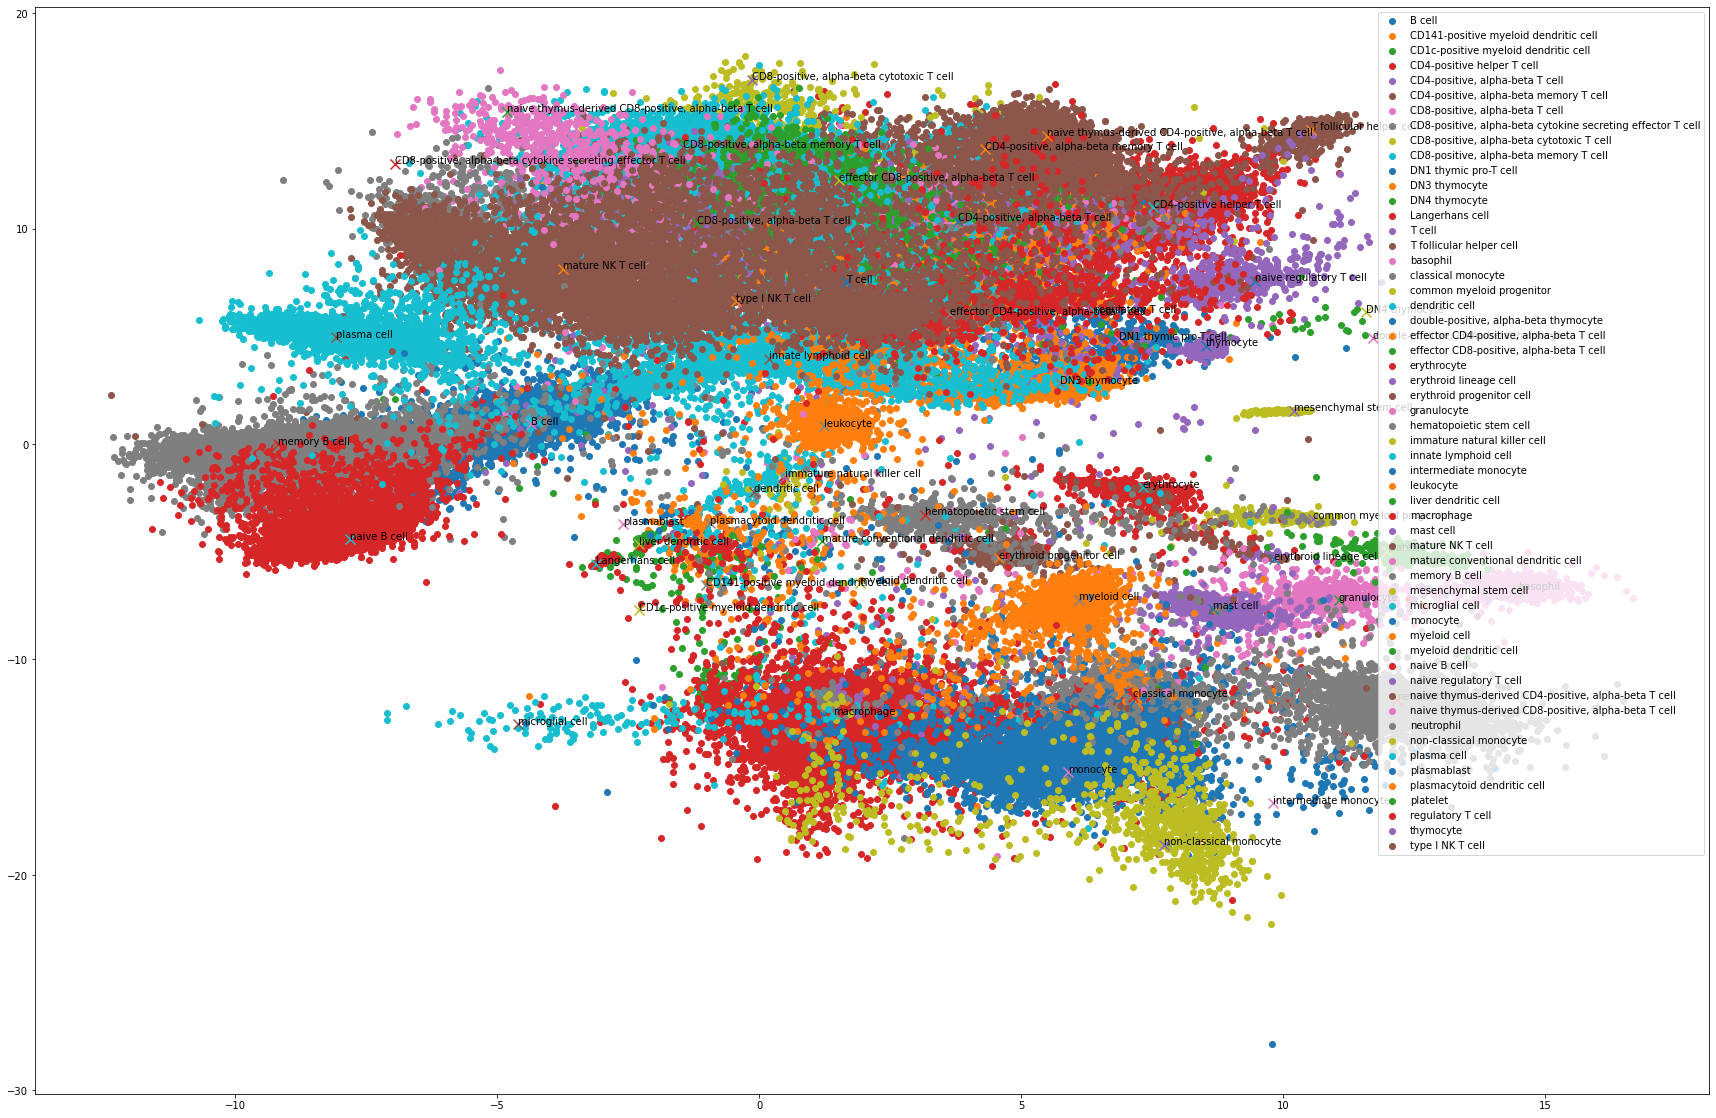

In [19]:
fig, ax = plt.subplots(figsize=(30, 20))
for color in np.unique(np.array(training_embeddings_true_labels)):
    i = np.where(np.array(training_embeddings_true_labels) == color)
    ax.scatter(np.array(training_embeddings)[i,0], np.array(training_embeddings)[i,1], label=color)
for i in range(embedding_prototypes.shape[0]):
    ax.scatter(embedding_prototypes[i,0], embedding_prototypes[i,1], marker='x', s=100)
    ax.annotate(embedding_prototypes_labels[i], (embedding_prototypes[i,0], embedding_prototypes[i,1]))
# ax.scatter(embedding_prototypes[:,0], embedding_prototypes[:,1], marker='x', s=100, label='Prototypes')
ax.legend()
plt.show()

Pred labels

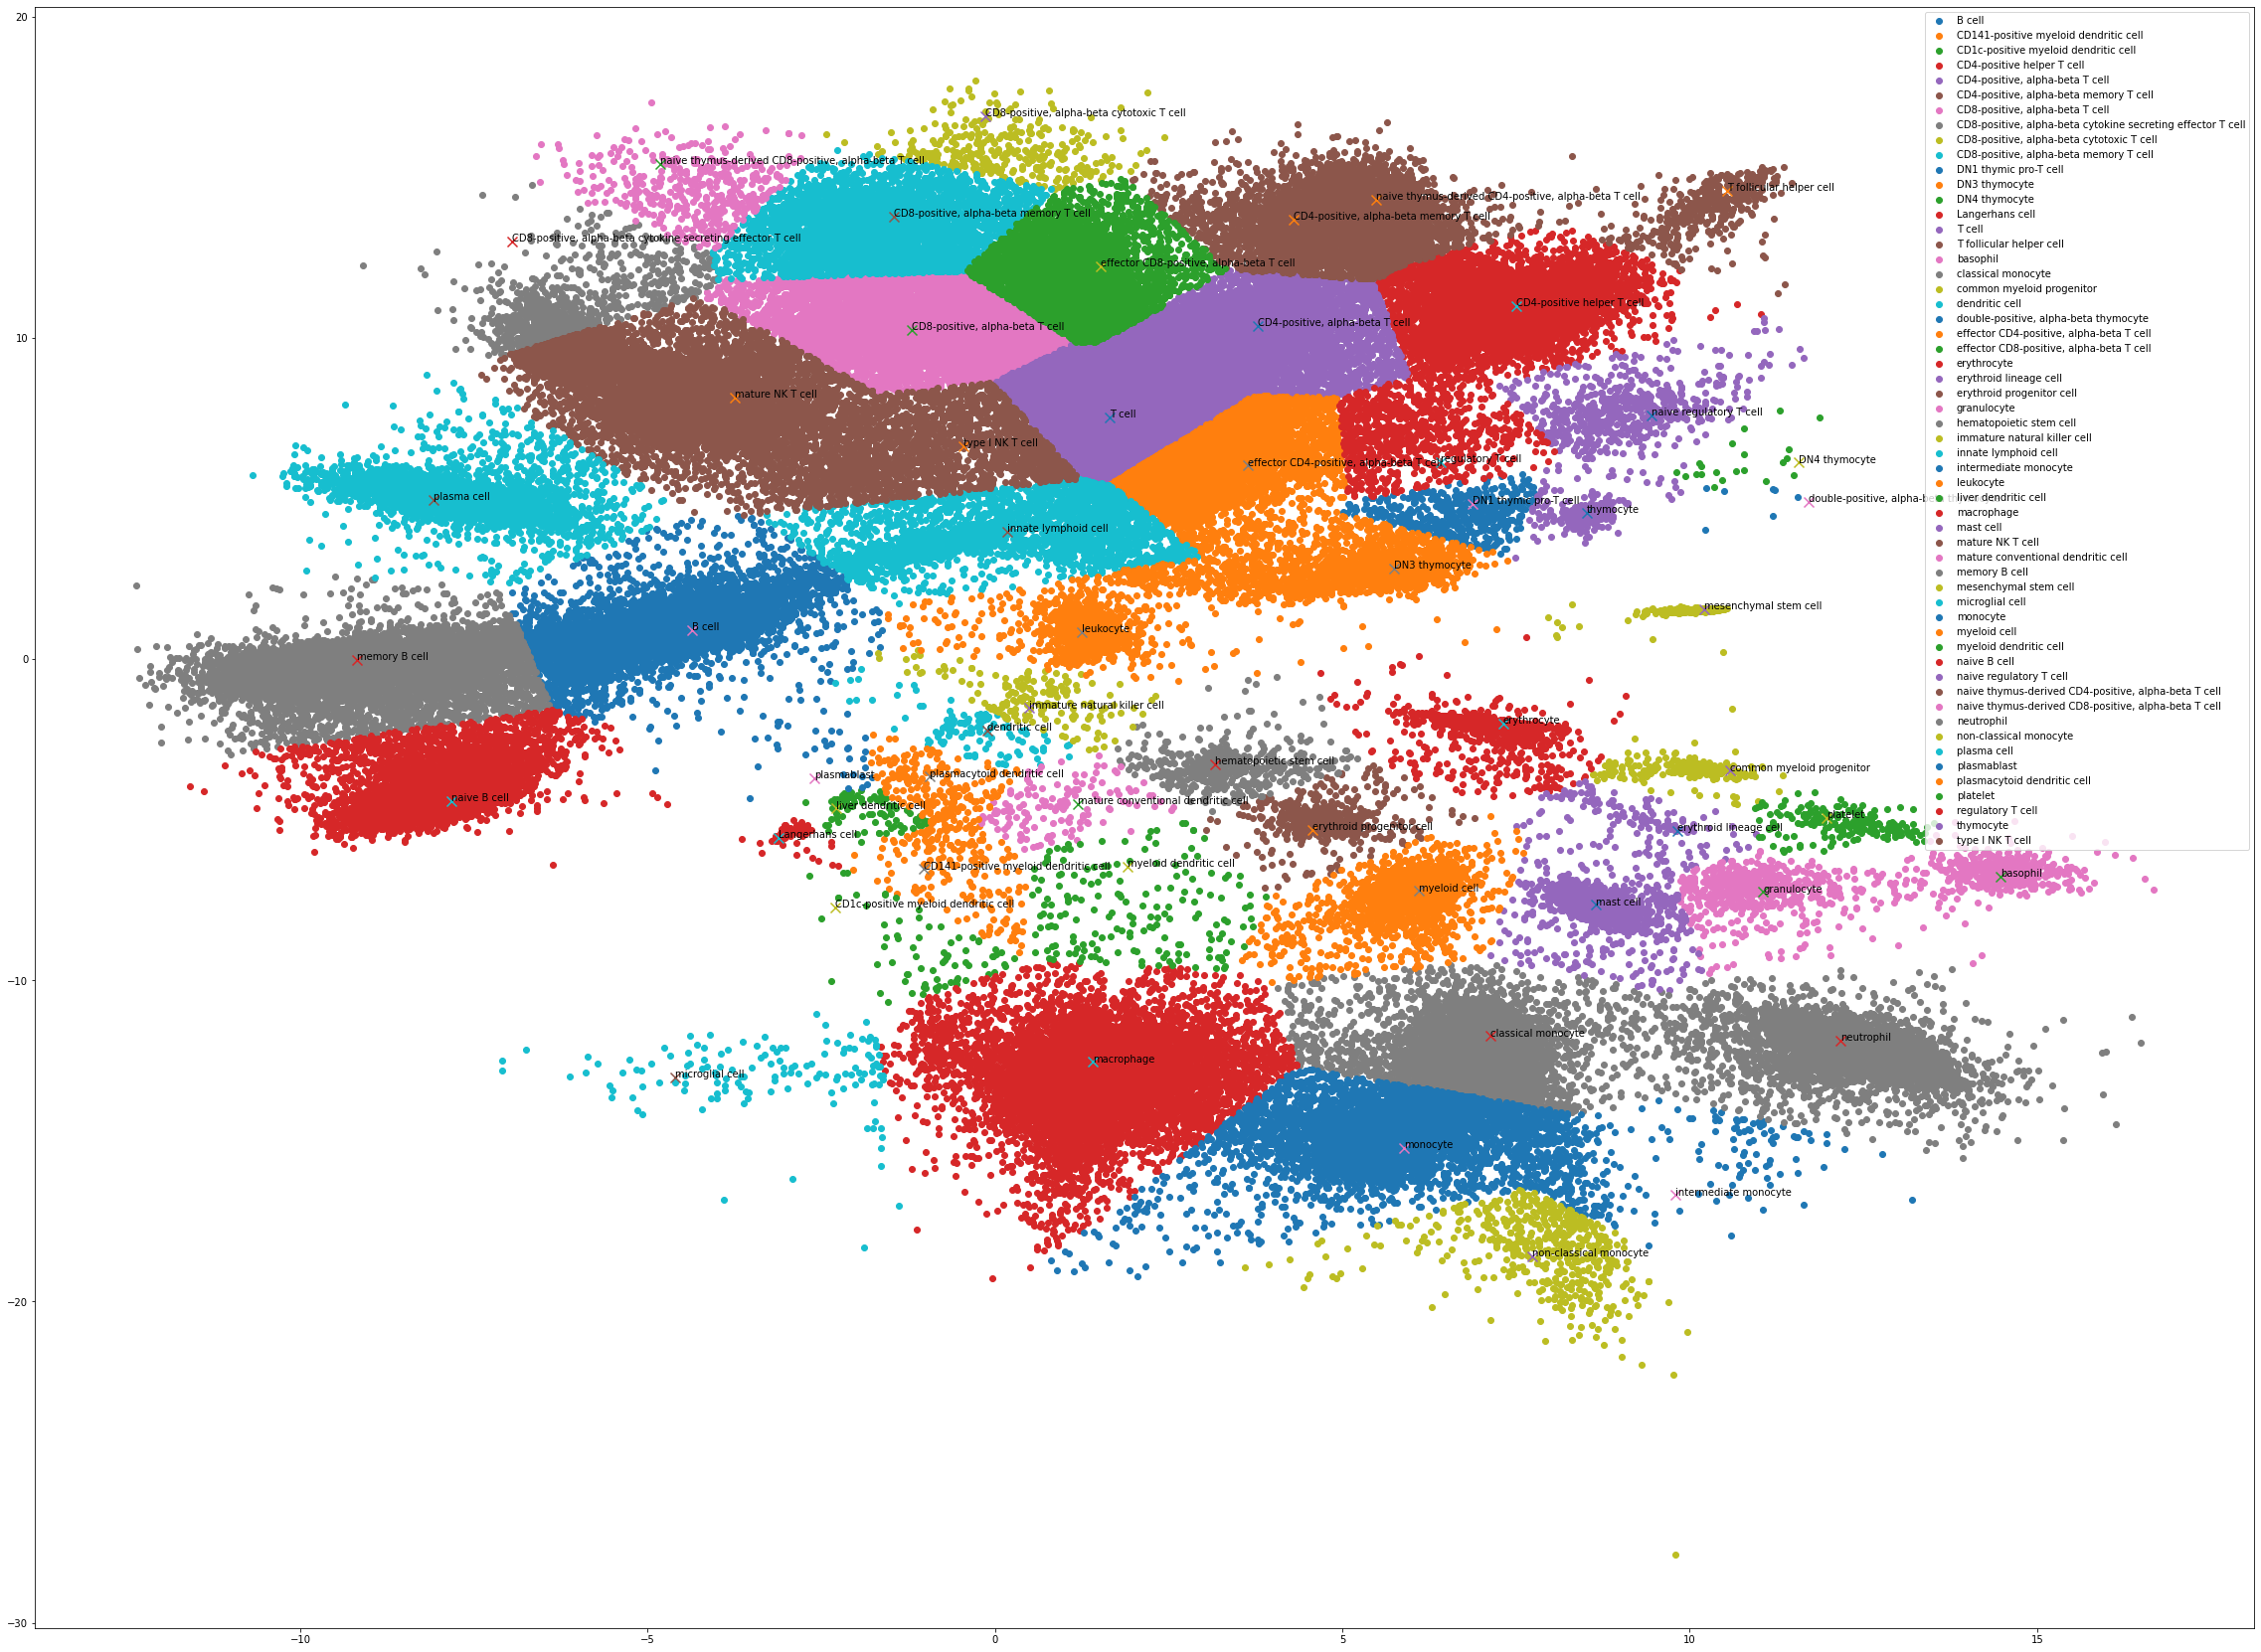

In [20]:
fig, ax = plt.subplots(figsize=(40, 30))
for color in np.unique(np.array(training_embeddings_pred_labels)):
    i = np.where(np.array(training_embeddings_pred_labels) == color)
    ax.scatter(np.array(training_embeddings)[i,0], np.array(training_embeddings)[i,1], label=color)
for i in range(embedding_prototypes.shape[0]):
    ax.scatter(embedding_prototypes[i,0], embedding_prototypes[i,1], marker='x', s=100)
    ax.annotate(embedding_prototypes_labels[i], (embedding_prototypes[i,0], embedding_prototypes[i,1]))
# ax.scatter(embedding_prototypes[:,0], embedding_prototypes[:,1], marker='x', s=100, label='Prototypes')
ax.legend()
plt.show()

Testing data

In [13]:
# testing
testing_out, testing_embeddings = model(torch.tensor(dataset[test_indices].X))
testing_embeddings_true_labels = dataset[test_indices].obs['cell_type']
testing_embeddings_pred_labels = []
testing_embeddings = testing_embeddings.detach().cpu().numpy()
testing_out = testing_out.detach().cpu().numpy()
for i in range(len(testing_out)):
    testing_embeddings_pred_labels.append(encoder_celltype.inverse_transform([testing_out[i].argmax()])[0])

True labels

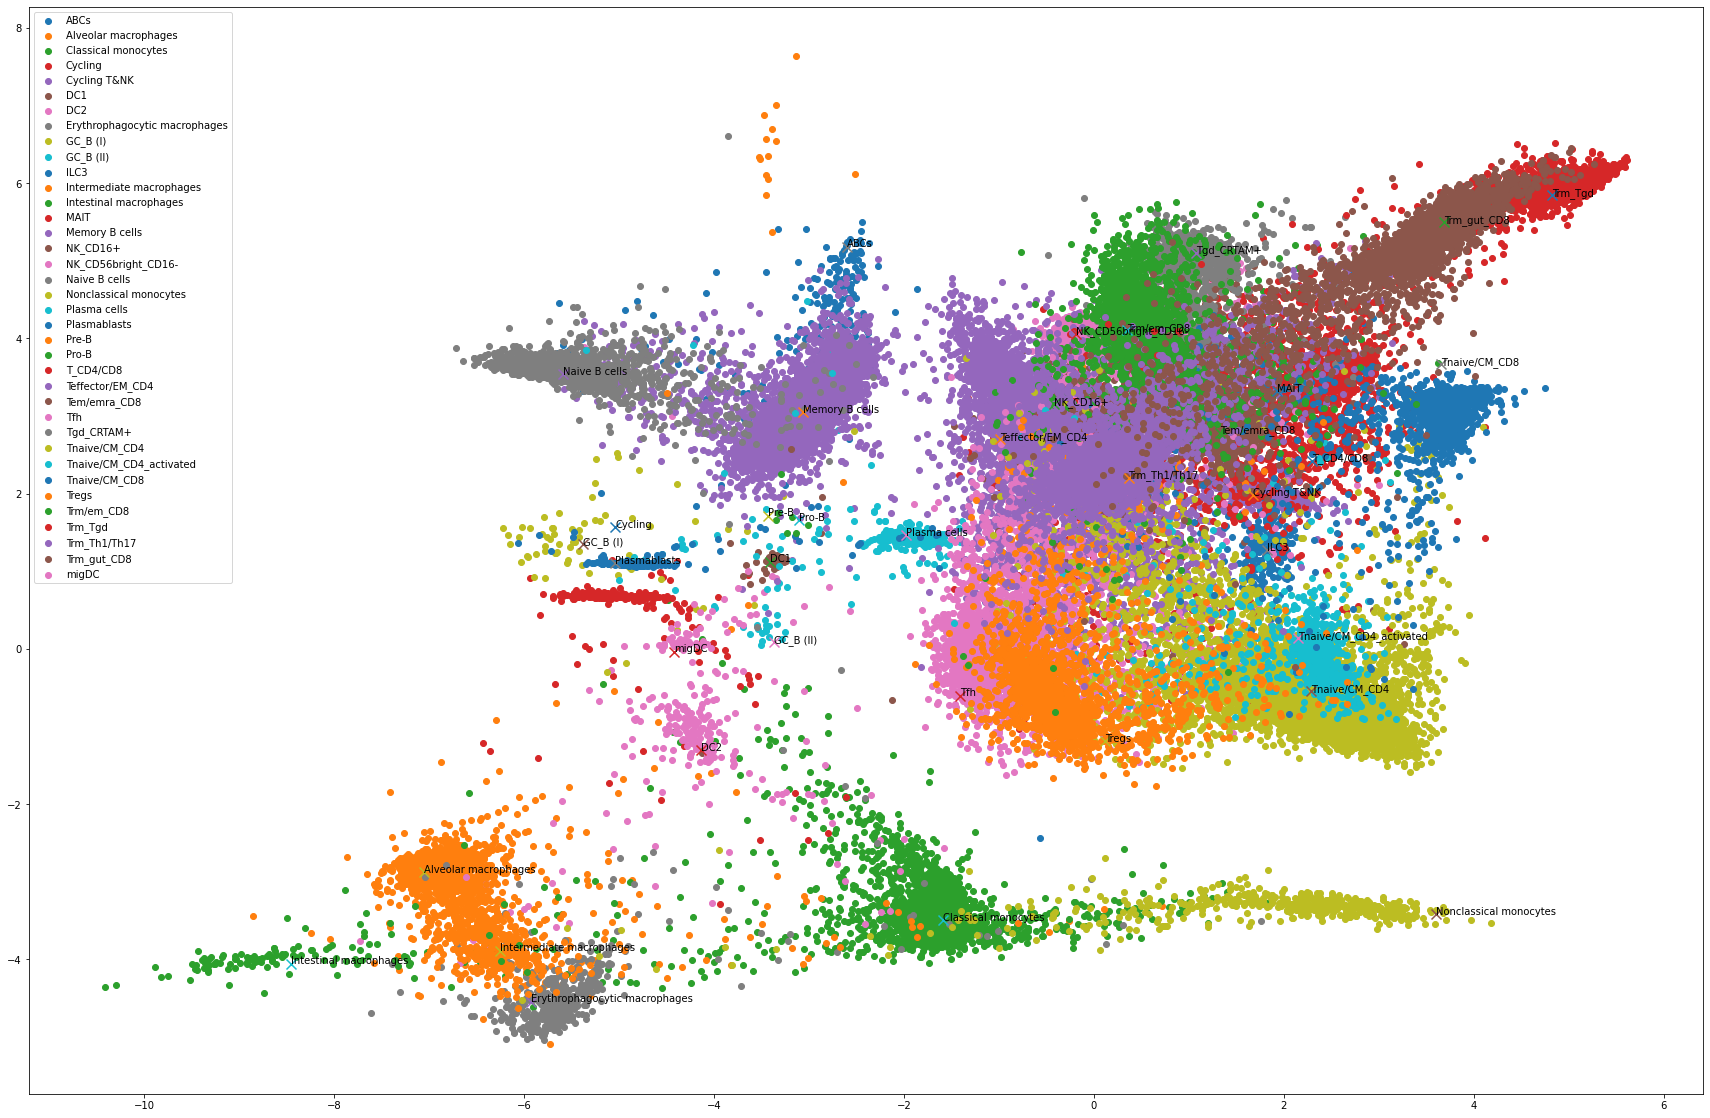

In [14]:
fig, ax = plt.subplots(figsize=(30, 20))
for color in np.unique(np.array(testing_embeddings_true_labels)):
    i = np.where(np.array(testing_embeddings_true_labels) == color)
    ax.scatter(np.array(testing_embeddings)[i,0], np.array(testing_embeddings)[i,1], label=color)
for i in range(embedding_prototypes.shape[0]):
    ax.scatter(embedding_prototypes[i,0], embedding_prototypes[i,1], marker='x', s=100)
    ax.annotate(embedding_prototypes_labels[i], (embedding_prototypes[i,0], embedding_prototypes[i,1]))
# ax.scatter(embedding_prototypes[:,0], embedding_prototypes[:,1], marker='x', s=100, label='Prototypes')
ax.legend()
plt.show()

Pred labels

In [15]:
fig, ax = plt.subplots(figsize=(30, 20))
for color in np.unique(np.array(testing_embeddings_pred_labels)):
    i = np.where(np.array(testing_embeddings_pred_labels) == color)
    ax.scatter(np.array(testing_embeddings)[i,0], np.array(testing_embeddings)[i,1], label=color)
for i in range(embedding_prototypes.shape[0]):
    ax.scatter(embedding_prototypes[i,0], embedding_prototypes[i,1], marker='x', s=100)
    ax.annotate(embedding_prototypes_labels[i], (embedding_prototypes[i,0], embedding_prototypes[i,1]))
# ax.scatter(embedding_prototypes[:,0], embedding_prototypes[:,1], marker='x', s=100, label='Prototypes')
ax.legend()
plt.show()

Likelihood

In [16]:
training_embeddings_pred_labels_int = encoder_celltype.transform(training_embeddings_pred_labels)
training_embeddings_true_labels_int = encoder_celltype.transform(training_embeddings_true_labels)
testing_embeddings_pred_labels_int = encoder_celltype.transform(testing_embeddings_pred_labels)
testing_embeddings_true_labels_int = encoder_celltype.transform(testing_embeddings_true_labels)

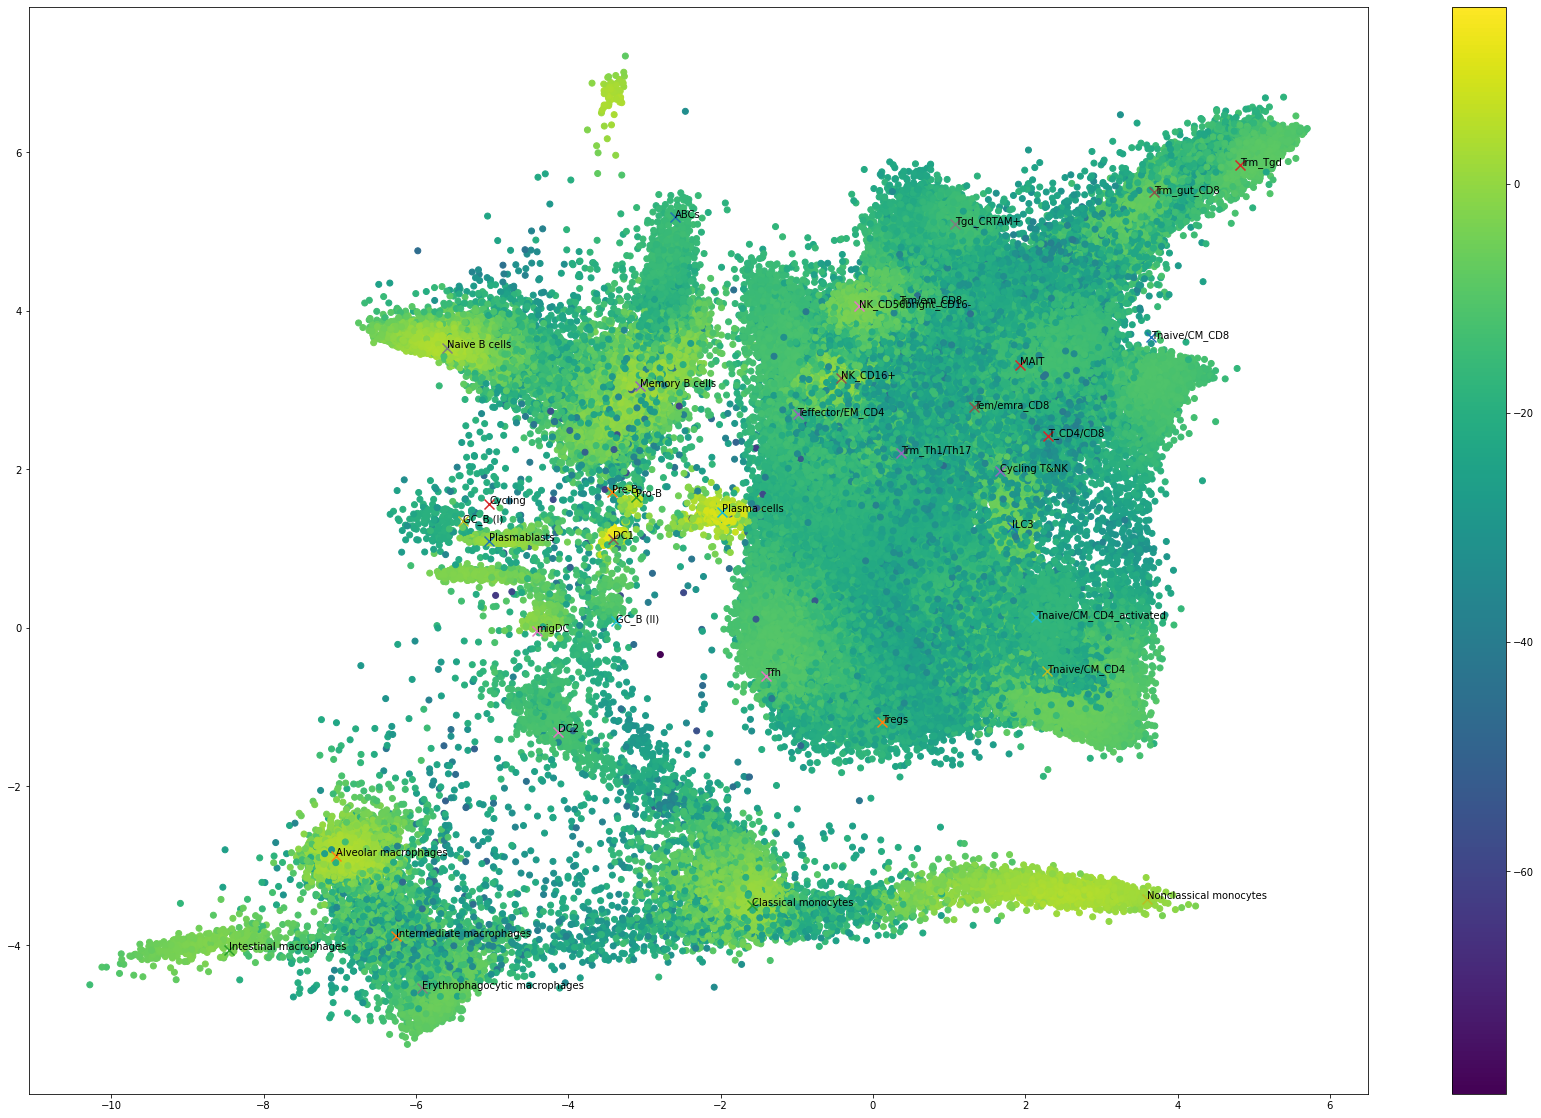

In [17]:
# Training
targets = torch.index_select(model.prototypes, 0, torch.tensor(training_embeddings_pred_labels_int))
log_vars = torch.log(torch.index_select(model.vars, 0, torch.tensor(training_embeddings_pred_labels_int)))
training_embedding_likelihoods = helper_fns.log_likelihood_student(torch.tensor(training_embeddings), targets, log_vars)
training_embedding_likelihoods = np.array(training_embedding_likelihoods.detach())

fig, ax = plt.subplots(figsize=(30, 20))
plt.rcParams["figure.autolayout"] = True
points = ax.scatter(np.array(training_embeddings)[:,0], np.array(training_embeddings)[:,1], c=training_embedding_likelihoods)
fig.colorbar(points)
for i in range(embedding_prototypes.shape[0]):
    ax.scatter(embedding_prototypes[i,0], embedding_prototypes[i,1], marker='x', s=100)
    ax.annotate(embedding_prototypes_labels[i], (embedding_prototypes[i,0], embedding_prototypes[i,1]))
plt.show()

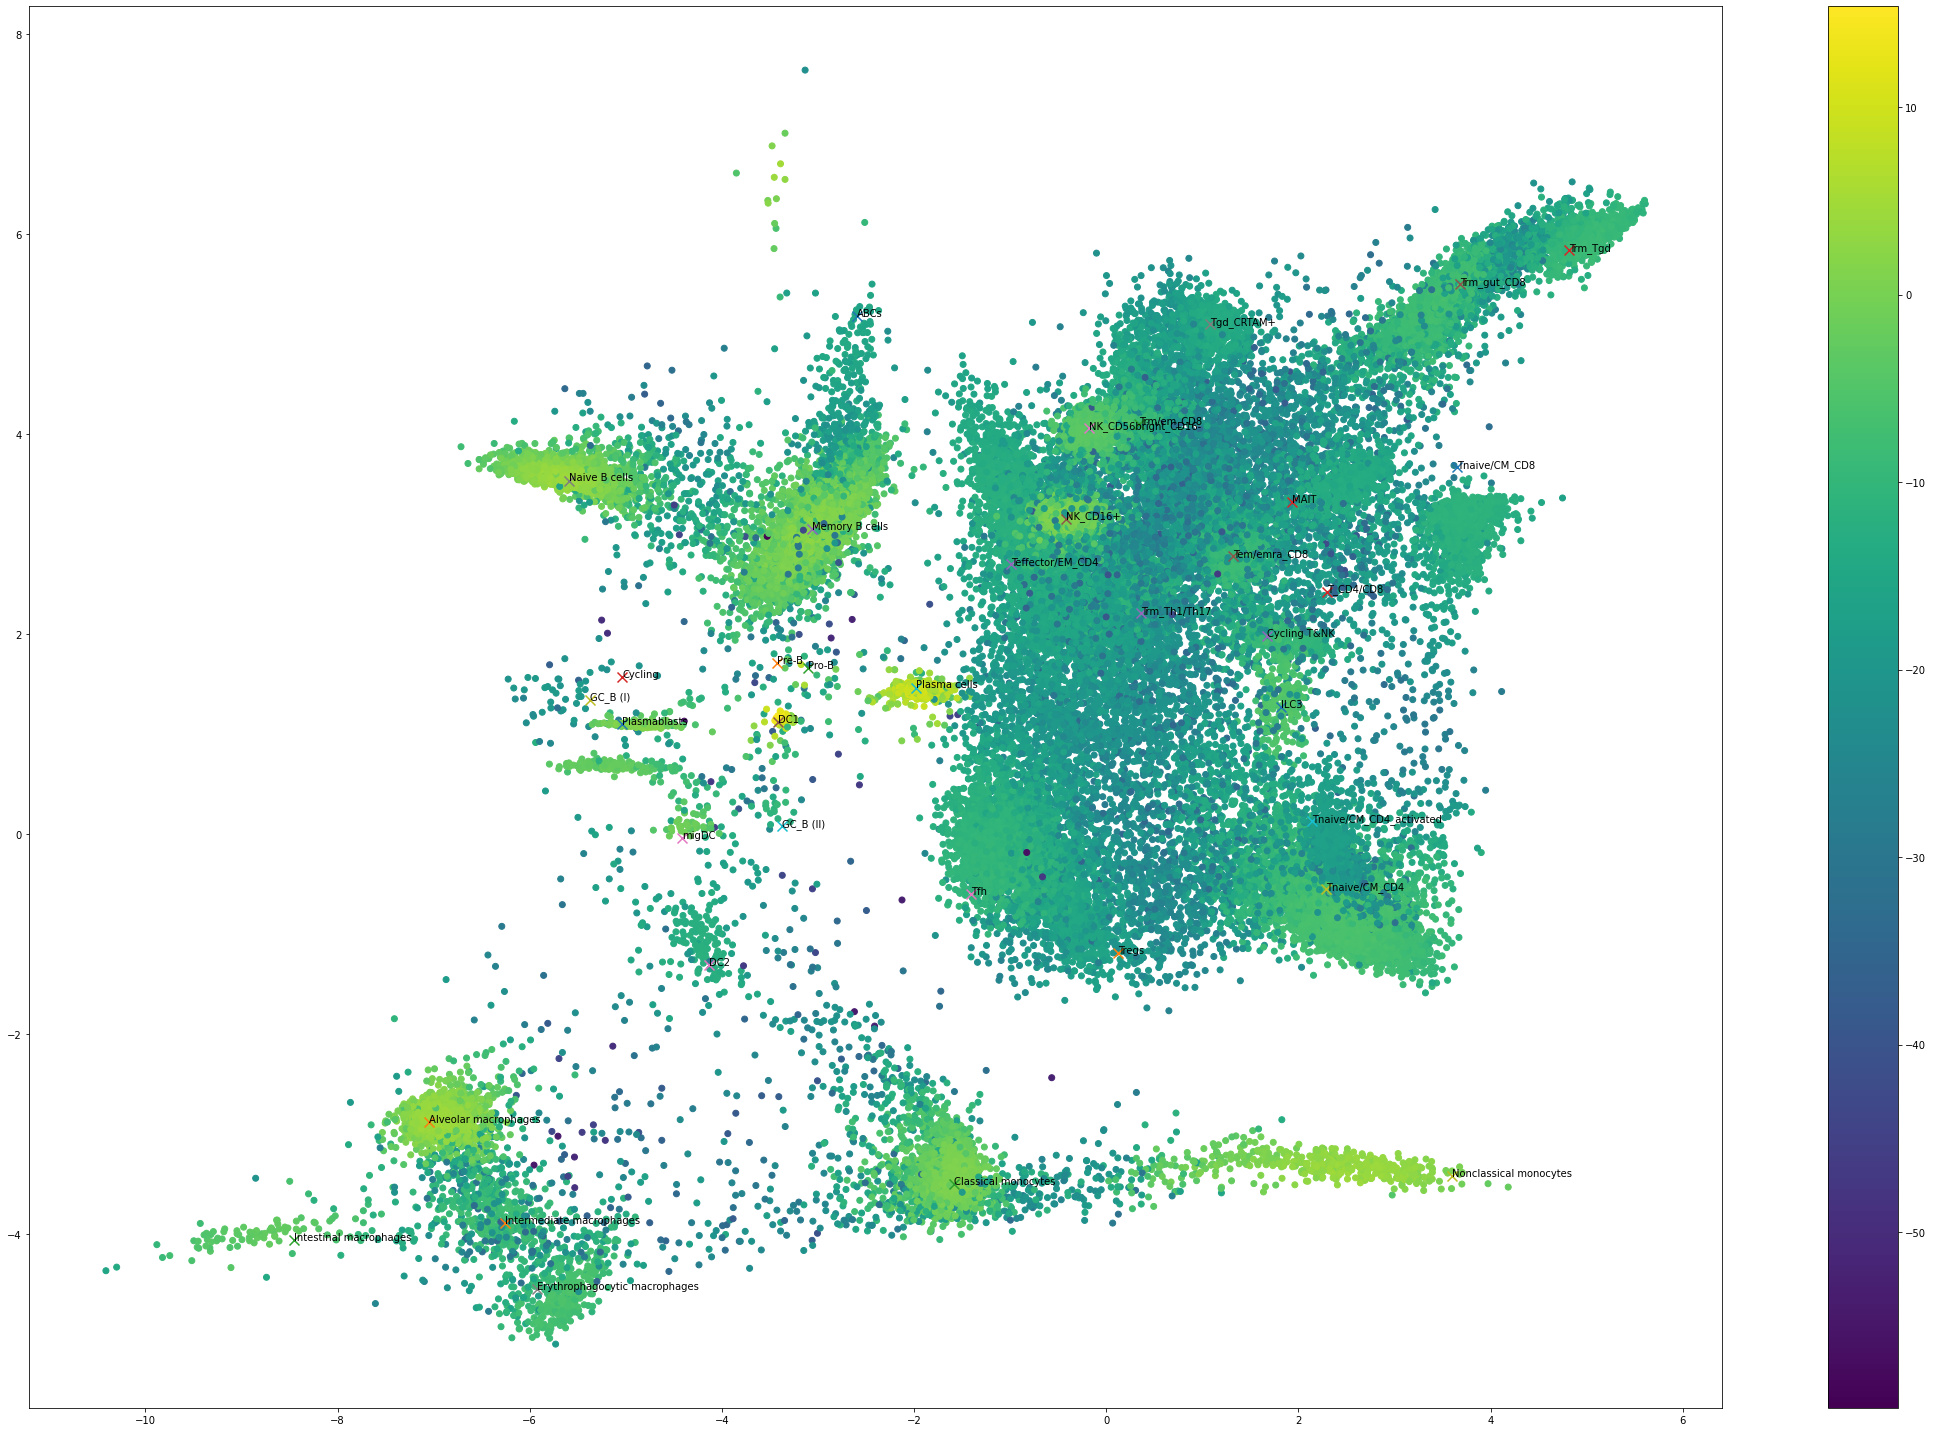

In [18]:
# Testing
targets = torch.index_select(model.prototypes, 0, torch.tensor(testing_embeddings_pred_labels_int))
log_vars = torch.log(torch.index_select(model.vars, 0, torch.tensor(testing_embeddings_pred_labels_int)))
testing_embedding_likelihoods = helper_fns.log_likelihood_student(torch.tensor(testing_embeddings), targets, log_vars)
testing_embedding_likelihoods = np.array(testing_embedding_likelihoods.detach())

fig, ax = plt.subplots(figsize=(30, 20))
plt.rcParams["figure.autolayout"] = True
points = ax.scatter(np.array(testing_embeddings)[:,0], np.array(testing_embeddings)[:,1], c=testing_embedding_likelihoods)
fig.colorbar(points)
for i in range(embedding_prototypes.shape[0]):
    ax.scatter(embedding_prototypes[i,0], embedding_prototypes[i,1], marker='x', s=100)
    ax.annotate(embedding_prototypes_labels[i], (embedding_prototypes[i,0], embedding_prototypes[i,1]))
plt.show()

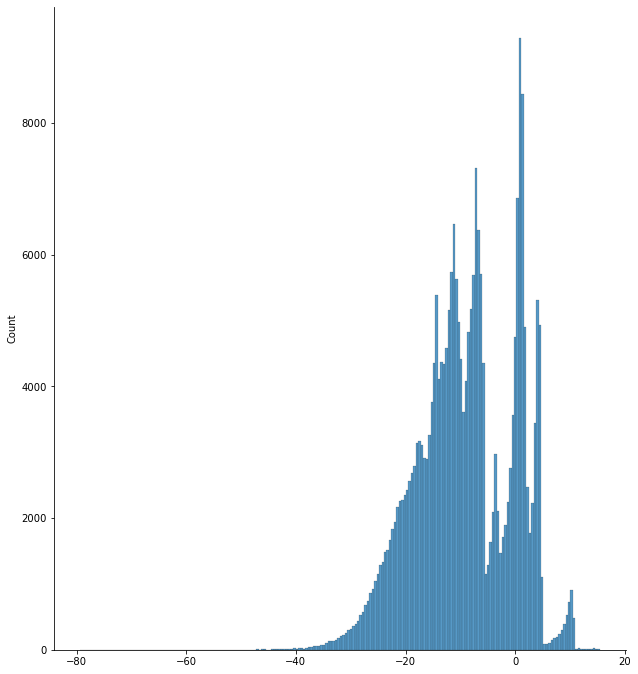

In [19]:
# Training
g = sns.displot(training_embedding_likelihoods)
g.fig.set_size_inches(10,10)

In [20]:
# Testing
g = sns.displot(testing_embedding_likelihoods)
g.fig.set_size_inches(10,10)

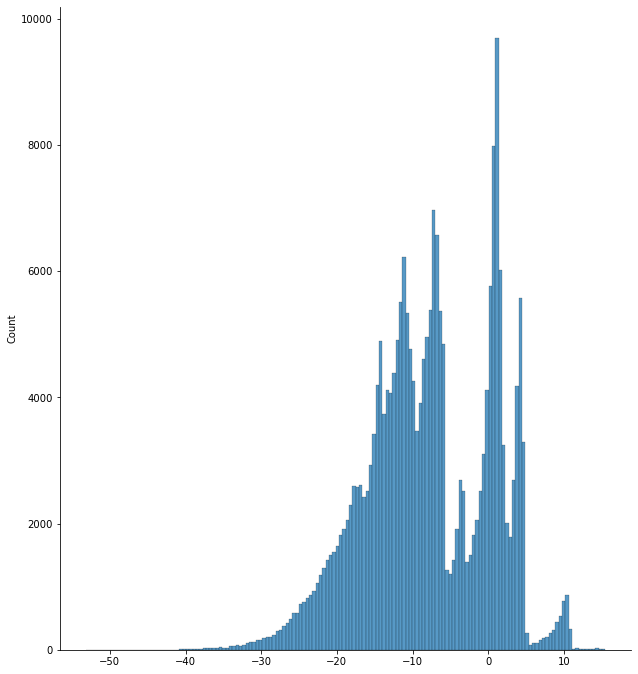

In [21]:
# Training True positive
true_pos_train = []
for i in range(len(training_embeddings_true_labels)):
    if training_embeddings_pred_labels_int[i] == training_embeddings_true_labels_int[i]:
        true_pos_train.append(training_embedding_likelihoods[i])

g = sns.displot(true_pos_train)
g.fig.set_size_inches(10,10)

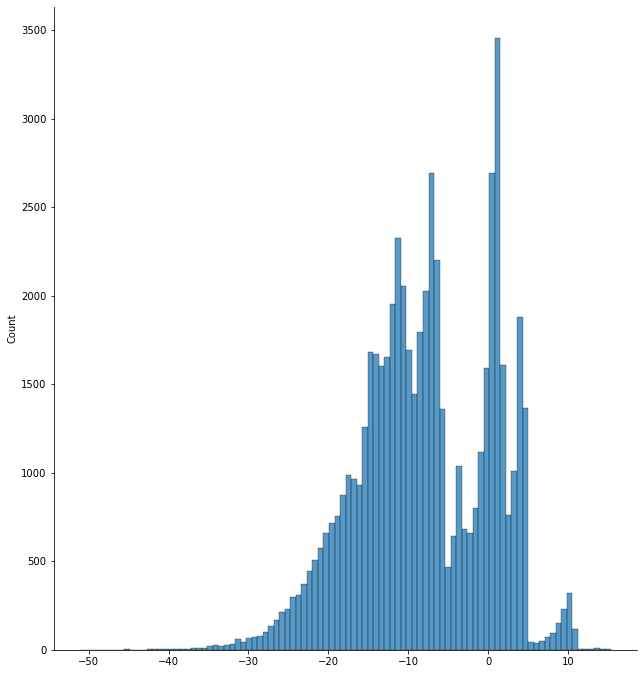

In [22]:
# Testing True positive
true_pos_test = []
for i in range(len(testing_embeddings_true_labels)):
    if testing_embeddings_pred_labels_int[i] == testing_embeddings_true_labels_int[i]:
        true_pos_test.append(testing_embedding_likelihoods[i])

g = sns.displot(true_pos_test)
g.fig.set_size_inches(10,10)

In [11]:
X_train = dataset[train_indices].X
X_test = dataset[test_indices].X
y_train = encoder_celltype.transform(dataset[train_indices].obs['cell_type'])
y_test = encoder_celltype.transform(dataset[test_indices].obs['cell_type'])

In [12]:
if torch.cuda.is_available():
    # y_pred, y_embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(torch.tensor(dataset[test_indices].X).cuda())
    y_pred, y_embeddings = model(torch.tensor(dataset[test_indices].X).cuda())
else:
    # y_pred, y_embeddings, x_hat, mean, log_var, decoder_mu, decoder_log_var = model(torch.tensor(dataset[test_indices].X))
    y_pred, y_embeddings = model(torch.tensor(dataset[test_indices].X))
y_pred = y_pred.detach().cpu().numpy()
y_pred_self = encoder_celltype.inverse_transform(y_pred.argmax(axis=1))

/Users/xbh0403/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing error: 17.73894975443899%
0.5451076690593124


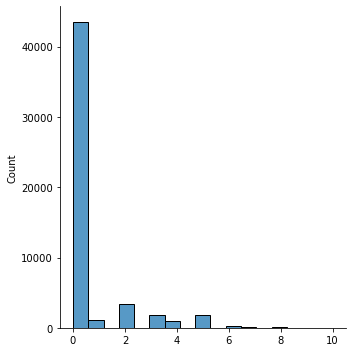

Training error: 17.217911687527135%


In [13]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)
print("Testing error: " + str(100 - 100*clf.score(X_test, y_test)) + "%")
log_reg_y_pred = clf.predict(X_test)
log_dist_list = []
for i in range(len(log_reg_y_pred)):
    distance = dist_df.iloc[log_reg_y_pred[i], y_test[i]]
    log_dist_list.append(distance)
print(np.mean(np.array(log_dist_list)))
sns.displot(log_dist_list)
plt.show(block=False)
print("Training error: " + str(100-100*clf.score(X_train, y_train)) + "%")

Training error: 12.591795510751169%
Testing error: 13.826973932754058%
0.46101246694370984


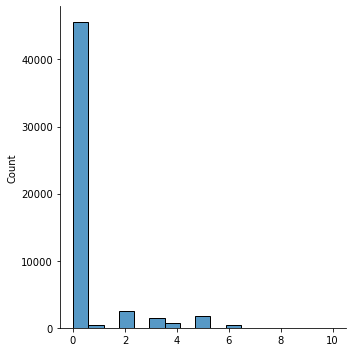

In [14]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(X_train, y_train)
print("Training error: " + str(100 - 100*knn.score(X_train, y_train)) + "%")
print("Testing error: " + str(100 - 100*knn.score(X_test, y_test)) + "%")
knn_y_pred = knn.predict(X_test)
knn_dist_list = []
for i in range(len(knn_y_pred)):
    distance = dist_df.iloc[knn_y_pred[i], y_test[i]]
    knn_dist_list.append(distance)
print(np.mean(np.array(knn_dist_list)))
sns.displot(knn_dist_list)
plt.show(block=False)